<a href="https://colab.research.google.com/github/njauflo/Blightbuster/blob/main/potato2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Mount google drive to access dataset
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Import necessary libraries
import tensorflow as tf
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [3]:
n_classes = 3
epochs = 10

train_path = '/content/drive/MyDrive/potato/train'
valid_path = '/content/drive/MyDrive/potato/valid'
test_path = '/content/drive/MyDrive/potato/test'


In [4]:
img_augmentation = Sequential(
    [
        preprocessing.RandomRotation(factor=0.15),
        preprocessing.RandomTranslation(height_factor=0.1, width_factor=0.1),
        preprocessing.RandomFlip(),
        preprocessing.RandomContrast(factor=0.1),
    ],
    name="img_augmentation",
)

def build_model(n_classes):
  inputs = layers.Input(shape=(224,224,3))
  x = img_augmentation(inputs)

  model = EfficientNetB0(include_top=False, input_tensor=x, weights="imagenet")

  model.trainable = False

#rebuild top
  x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
  x = layers.BatchNormalization()(x)

  top_dropout_rate = 0.2
  x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
  outputs = layers.Dense(n_classes, activation="softmax", name="pred")(x)

  model = tf.keras.Model(inputs, outputs, name="EfficientNet")
  optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)
  model.compile(
      optimizer, loss="categorical_crossentropy",metrics=["accuracy"]
  )

  return model


In [5]:
def unfreeze_model(model):
    for layer in model.layers[-20:]:
      if not isinstance(layer, layers.BatchNormalization):
        layer.trainable = True

        optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
        model.compile(
            optimizer,loss="categorical_crossentropy", metrics=["accuracy"]
        )

In [9]:
def test_model(model,test_ds):

    test_labels = test_ds.classes
    class_names = list(test_ds.class_indices.keys())
    print("Class names:", class_names)

    predictions = model.predict(test_ds, steps=len(test_ds), verbose=0)
    predicted_labels = np.argmax(predictions, axis=1)

    accuracy = accuracy_score(test_labels, predicted_labels)
    print(f"Accuracy: {accuracy*100}%")

  # Iterate over the images and labels in the first batch
    images_batch, labels_batch = next(test_ds)
    first_image = images_batch[0].astype('uint8')

    first_label = np.argmax(labels_batch[0])
    print("first predicted image")

    plt.imshow(first_image)
    print("actual label:", class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print(np.argmax(batch_prediction[0]))



    cm = confusion_matrix(test_labels, predicted_labels)
    plt.figure(figsize=(10,7))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.show()

    report = classification_report(test_labels, predicted_labels, target_names=class_names)
    print("Classification report:\n", report)

In [7]:
if __name__ == "__main__":

    model = build_model(n_classes)
    unfreeze_model(model)

    train_ds = ImageDataGenerator(preprocessing_function=tf.keras.applications.efficientnet.preprocess_input).flow_from_directory(
        directory=train_path, target_size=(224,224), batch_size=10)
    valid_ds = ImageDataGenerator(preprocessing_function=tf.keras.applications.efficientnet.preprocess_input).flow_from_directory(
        directory=valid_path, target_size=(224,224), batch_size=10)
    test_ds = ImageDataGenerator(preprocessing_function=tf.keras.applications.efficientnet.preprocess_input).flow_from_directory(
        directory=test_path, target_size=(224,224), batch_size=1, shuffle=False)


    history = model.fit(train_ds, epochs=epochs, validation_data=valid_ds, verbose=1)


16705208/16705208 [==============================] - 0s 0us/step
Found 4656 images belonging to 3 classes.
Found 511 images belonging to 3 classes.
Found 405 images belonging to 3 classes.
Epoch 1/10
466/466 [==============================] - 897s 2s/step - loss: 0.3475 - accuracy: 0.8662 - val_loss: 0.1109 - val_accuracy: 0.9589
Epoch 2/10
466/466 [==============================] - 21s 46ms/step - loss: 0.1863 - accuracy: 0.9332 - val_loss: 0.0790 - val_accuracy: 0.9765
Epoch 3/10
466/466 [==============================] - 23s 49ms/step - loss: 0.1353 - accuracy: 0.9549 - val_loss: 0.1105 - val_accuracy: 0.9569
Epoch 4/10
466/466 [==============================] - 21s 44ms/step - loss: 0.1071 - accuracy: 0.9622 - val_loss: 0.0802 - val_accuracy: 0.9706
Epoch 5/10
466/466 [==============================] - 21s 45ms/step - loss: 0.1130 - accuracy: 0.9618 - val_loss: 0.0572 - val_accuracy: 0.9824
Epoch 6/10
466/466 [==============================] - 21s 45ms/step - loss: 0.0934 - accurac

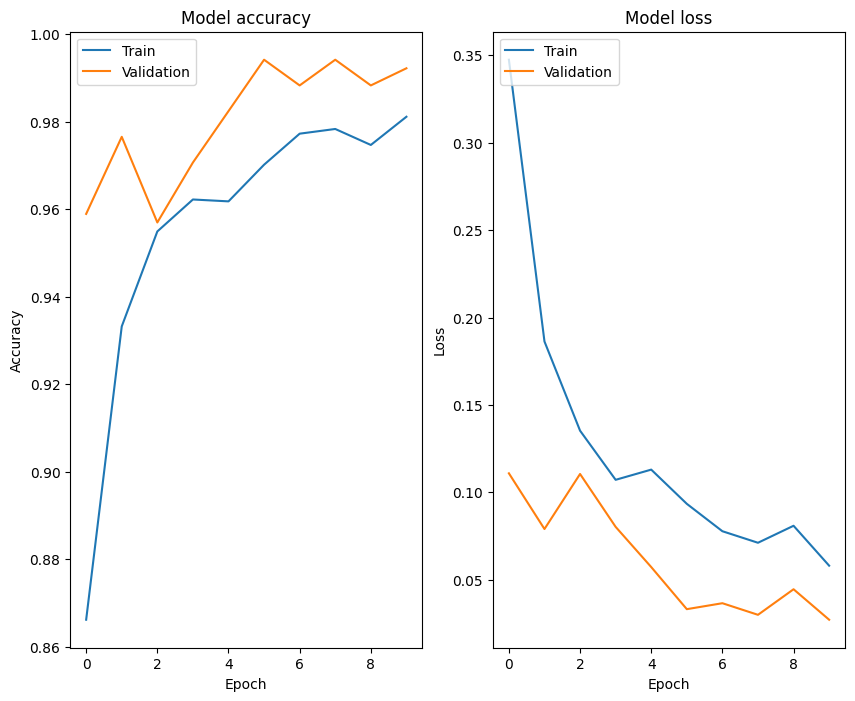

Class names: ['Early_Blight', 'Healthy', 'Late_Blight']
Accuracy: 98.27160493827161%
first predicted image
actual label: Early_Blight
1/1 [==============================] - 2s 2s/step
0


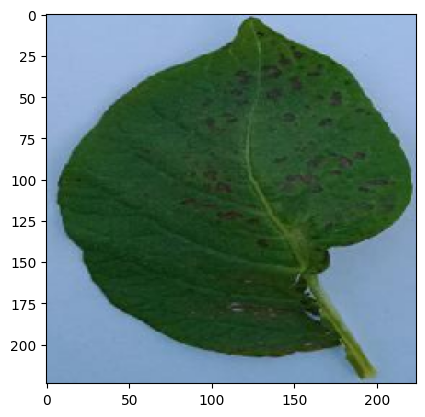

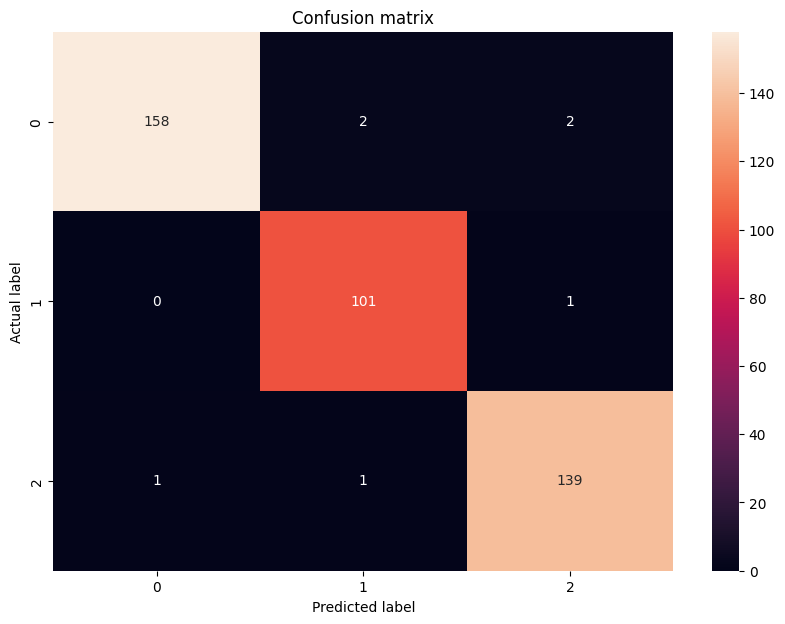

Classification report:
               precision    recall  f1-score   support

Early_Blight       0.99      0.98      0.98       162
     Healthy       0.97      0.99      0.98       102
 Late_Blight       0.98      0.99      0.98       141

    accuracy                           0.98       405
   macro avg       0.98      0.98      0.98       405
weighted avg       0.98      0.98      0.98       405



/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [10]:
# Plot training & validation accuracy values
plt.figure(figsize=(10, 8))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

test_model(model, test_ds)

model.save('/content/drive/My Drive/efficientmodel.h5')

In [11]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open('model.tflite', 'wb') as f:
  f.write(tflite_model)
